# Week 2 Challenge : Customer Experience Analytics for Fintech Apps


In [26]:
!pip install google-play-scraper
!pip install googletrans==4.0.0-rc1
!pip install langdetect


## Google playstore scraper

In [ ]:
from google_play_scraper import reviews_all
import pandas as pd

apps = {
    "CBE": "com.combanketh.mobilebanking",
    "BOA": "com.boa.boaMobileBanking",
    "Dashen": "com.dashen.dashensuperapp"
}

data = []

for bank, app_id in apps.items():
    print(f"Scraping {bank}")
    reviews = reviews_all(
        app_id,
        sleep_milliseconds=0,
        lang='en',
        country='et'
    )
    print(reviews)
    for r in reviews:
        data.append({
            "id" : r['reviewId'],
            "review": r["content"],
            "rating": r["score"],
            "date": pd.to_datetime(r["at"]).date(),
            "bank": bank,
            "source": r["userName"]
        })


df = pd.DataFrame(data)
df.drop_duplicates(subset='id', inplace=True)

## Describing the dataset

In [28]:
print(df.describe())
print (df.info())

            rating
count  8991.000000
mean      3.959404
std       1.559505
min       1.000000
25%       3.000000
50%       5.000000
75%       5.000000
max       5.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8991 entries, 0 to 8990
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8991 non-null   object
 1   review  8984 non-null   object
 2   rating  8991 non-null   int64 
 3   date    8991 non-null   object
 4   bank    8991 non-null   object
 5   source  8991 non-null   object
dtypes: int64(1), object(5)
memory usage: 421.6+ KB
None


In [29]:
print(df.groupby('bank').describe())

        rating                                             
         count      mean       std  min  25%  50%  75%  max
bank                                                       
BOA     1045.0  3.065072  1.860966  1.0  1.0  3.0  5.0  5.0
CBE     7498.0  4.053214  1.487208  1.0  3.0  5.0  5.0  5.0
Dashen   448.0  4.475446  1.201909  1.0  5.0  5.0  5.0  5.0


            rating
count  8991.000000
mean      3.959404
std       1.559505
min       1.000000
25%       3.000000
50%       5.000000
75%       5.000000
max       5.000000


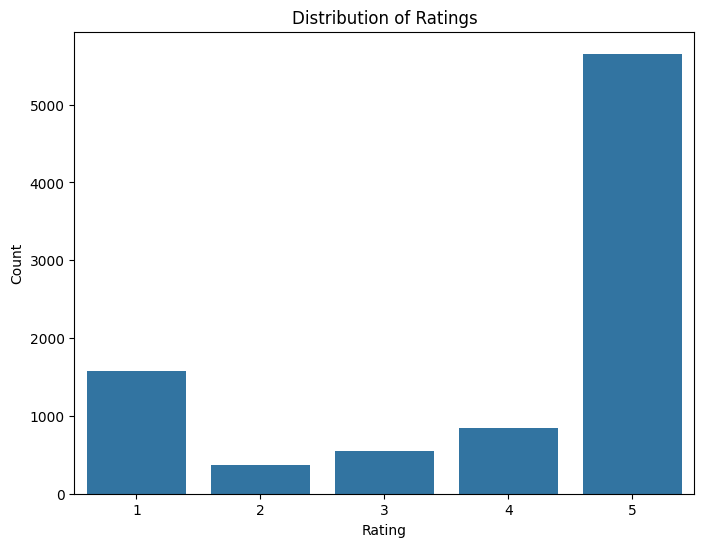

<ipython-input-30-0d5cb6f7eb7e>:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='bank', y='rating', ci=None)


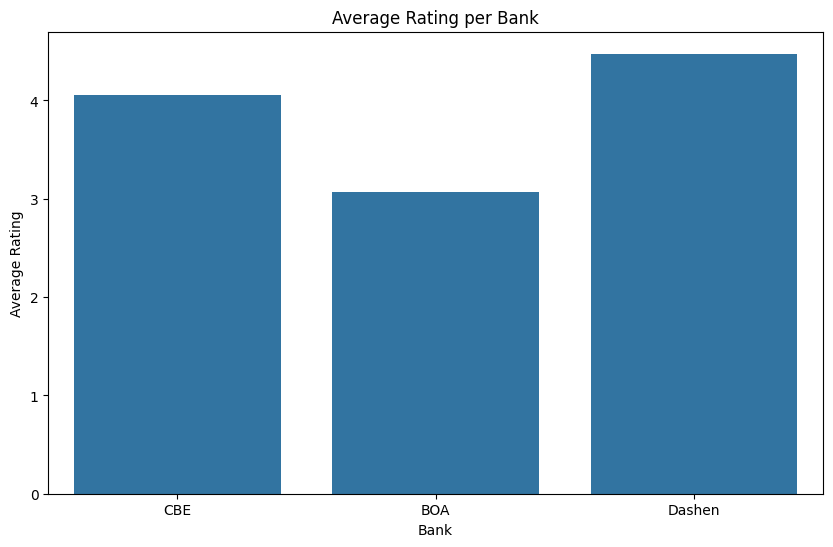

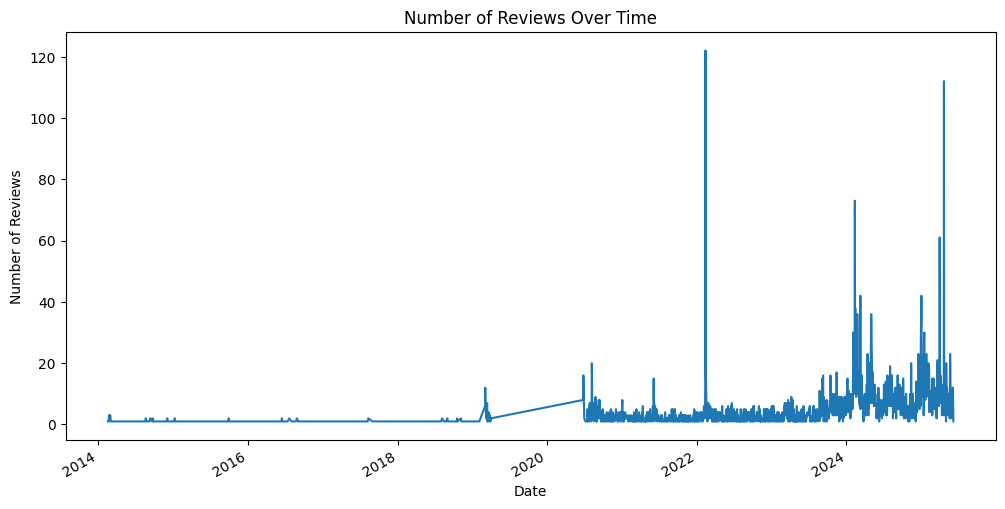

<Figure size 1200x600 with 0 Axes>

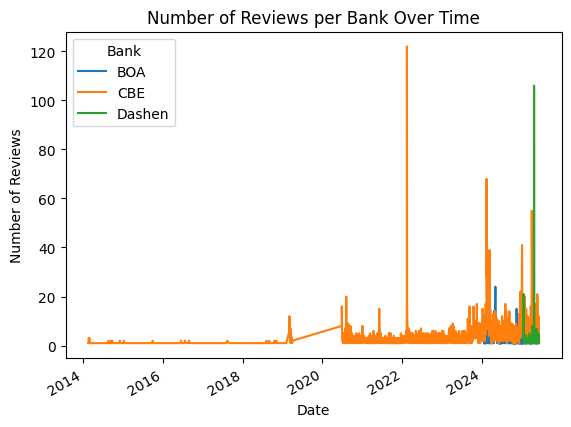

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Get descriptive statistics for numerical columns (ratings)
print(df.describe())

# Visualize the distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='rating')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Visualize the average rating per bank
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='bank', y='rating', ci=None)
plt.title('Average Rating per Bank')
plt.xlabel('Bank')
plt.ylabel('Average Rating')
plt.show()

# Visualize the number of reviews over time
df['date'] = pd.to_datetime(df['date'])
plt.figure(figsize=(12, 6))
df.groupby('date').size().plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

# Visualize the number of reviews per bank over time
plt.figure(figsize=(12, 6))
df.groupby(['date', 'bank']).size().unstack().plot(kind='line')
plt.title('Number of Reviews per Bank Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.legend(title='Bank')
plt.show()


## Translating the reviews to English

In [31]:
!pip install emoji

In [32]:
import pandas as pd
import time
import emoji
from googletrans import Translator

# Initialize translator
translator = Translator()

# Ensure 'review' column is string
df['review'] = df['review'].astype(str)

translated_reviews = []

def safe_translate(text, max_retries=10):
    for attempt in range(max_retries):
        try:
            return translator.translate(text, dest='en').text
        except Exception as e:
            print(f"Retry {attempt+1}/{max_retries} failed — {e}")
            time.sleep(2)  # Wait before retrying
    return text  # Return original if all retries fail

for i, text in enumerate(df['review']):
    try:
        if not text.strip():
            translated_reviews.append(text)
            continue

        # Convert emojis to descriptive words
        text_no_emoji = emoji.demojize(text).replace(":", " ").replace("_", " ")

        # Translate with retry
        translated = safe_translate(text_no_emoji)

        print(f"[{i}] {text} ===> {translated}")
        translated_reviews.append(translated)

    except Exception as e:
        print(f"[{i}] Unexpected Error: {e} — {text[:60]}...")
        translated_reviews.append(text)

# Assign to DataFrame
df['translated_review'] = translated_reviews

# Remove duplicates by 'id' if exists
if 'id' in df.columns:
    df.drop_duplicates(subset='id', inplace=True)
else:
    df.drop_duplicates(inplace=True)

# Save result
df.to_csv("clean_reviews_trans.csv", index=False, encoding='utf-8-sig')

# Show sample
print(df[['review', 'translated_review']].head())


Streaming output truncated to the last 5000 lines.
Retry 3/10 failed — 'Translator' object has no attribute 'raise_Exception'
[4774] Good job kep it up ===> Good job kep it up
[4775] I use this up it was very convenient and fast to transfer and receive money ===> I use this up it was very convenient and fast to transfer and receive money
[4776] 👍👍👍 ===> thumbs up  thumbs up  thumbs up
[4777] baaye gaari dha ===> Left gari d
[4778] Where can i get verfication code ===> Where can i get verfication code
[4779] Good job ===> Good job
[4780] I have been using this app for long period of time & I'm very happy. because I'm also use other banks app and nothing can compare this. I know so many people using this app too & we all happier by using this app especially it gives us very helpful recently data for long period of time which is the money we sent and received with very clear info. And its reduced the time which we spend by printing statement on branches. But on this version this future sh